In [1]:
import os
import sys
sys.path.append(os.getenv('BONNER_ROOT_PATH'))
from tools import *
import matplotlib.colors as mcolors

PREDS_PATH = '/data/atlas/.cache/beta_predictions'
PATH_TO_BOOTSTRAP = '/home/akazemi3/Desktop/untrained_models_of_visual_cortex/model_evaluation/results/predicting_brain_data/bootstrap_data'

In [2]:
DATASET_INFO_DICT = {
    
    'naturalscenes':{
        'subjects':[i for i in range(8)],
        'regions':['ventral visual stream','midventral visual stream','early visual stream'],
        'expansion_features':[3,30,300,3000],
        'vit_features':[12,5*12, 50*12],
        'test_data_size':872
    },
    
    'majajhong':{
        'subjects':['Tito','Chabo'],
        'regions':['V4','IT'],
        'expansion_features':[3,30,300,3000,30000],
        'vit_features':[12,5*12, 50*12, 500*12],
        'test_data_size':640
    }
}

# Main Results

#### run bootstrap

In [14]:
#run bootstrap 

#dataset = 'naturalscenes'
dataset = 'majajhong'
info_dict = DATASET_INFO_DICT[dataset]

n_rows = info_dict['test_data_size']
all_sampled_indices = np.random.choice(n_rows, (1000, n_rows), replace=True) # Sample indices for all bootstraps at once

for region in info_dict['regions']:
     
    # engineered models 
    get_bootstrap_data(models= ['expansion','expansion_linear','fully_connected'],
                        features=info_dict['expansion_features'],
                        dataset=dataset, 
                        subjects=info_dict['subjects'],
                        layers = 5,
                        file_name = 'engineered',
                        region=region,
                        all_sampled_indices=all_sampled_indices)
    
    # # vit models
    # get_bootstrap_data(models= ['ViT'],
    #                     features=info_dict['vit_features'],
    #                     dataset=dataset, 
    #                     subjects=info_dict['subjects'],
    #                     layers = 5,
    #                     file_name = 'ViT',
    #                     region=region,
    #                     all_sampled_indices=all_sampled_indices)
    
    # # alexnet
    # get_bootstrap_data(models=['alexnet'],
    #                     features=[None],
    #                     dataset=dataset, 
    #                     subjects=info_dict['subjects'],
    #                     layers='best',
    #                     file_name='alexnet',
    #                     region=region,
    #                     all_sampled_indices=all_sampled_indices)

100%|███████████████████████████████████| 2/2 [00:00<00:00,  8.41it/s]


#### loading bootstrap data

In [12]:
DATASET = 'majajhong' # one of ['majajhong', 'naturalscenes']
region = 'V4' # for majajhong: [V4,IT], for naturalscenes: [early visual stream, midventral visual stream, ventral visual stream]

DATASET = 'naturalscenes'
region = 'ventral visual stream'#, ventral visual stream]

In [13]:
# vit data
with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-vit-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_vit = pickle.load(file)
    
# expansion model and MLP data
with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-engineered-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_engineered = pickle.load(file)
    
# alexnet data
with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-alexnet-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_alexnet = pickle.load(file)  

In [14]:
df_engineered['features'] = df_engineered['features'].apply(lambda x: int(x)*36) # multiply by spatial dims
df_vit['features'] = df_vit['features'].apply(lambda x: int(x)*196) # multiply by spatial dims
df = pd.concat([df_engineered,df_vit]).reset_index(drop=True)

names ={'expansion':'Convolutional','ViT':'Transformer','fully_connected':'Fully connected'}
palette ={'Convolutional':'royalblue','Transformer':'palevioletred','Fully connected':'darkviolet'}

df['model'] = df['model'].map(names)
df['color'] = df['model'].map(palette)

df = df.dropna(subset='model').reset_index()

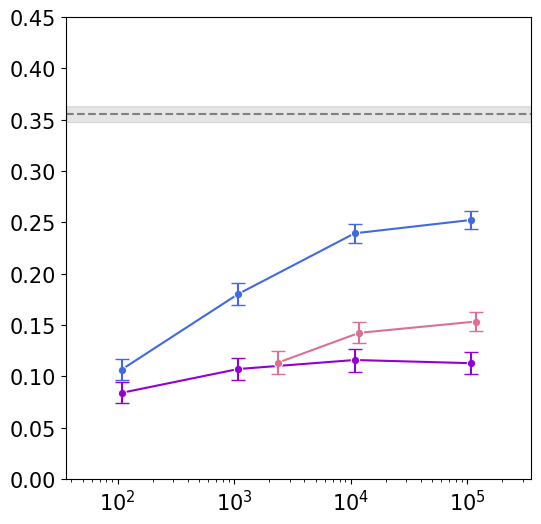

In [15]:
rcParams['figure.figsize'] = (6,6)  


# main plot
ax1 = sns.lineplot(data = df, x='features', y='score', hue='model', marker='o', palette = palette)
# adding error bars for the 95% confidence interval
for i in range(len(df)):
    plt.errorbar(df['features'][i], df['score'][i], 
                 yerr=[[df['score'][i] - df['lower'][i]], [df['upper'][i] - df['score'][i]]], 
                 fmt='none', capsize=5, color=df['color'][i])   
    
# alexnet 
plt.axhline(y=df_alexnet['score'][0], color='gray', linestyle='--', label='AlexNet')
# adding 95% confidence interval 
plt.fill_between(np.arange(df['features'].min()/3,df['features'].max()*3), 
                 df_alexnet['lower'], df_alexnet['upper'], color='gray', alpha=0.2)



plt.ylim(0,0.45) if DATASET == 'naturalscenes' else plt.ylim(0,0.65)
plt.xlabel('')
plt.ylabel('')
plt.xlim(df['features'].min()/3,df['features'].max()*3)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")        
ax1.legend(frameon=False,fontsize=12) if region == 'V4' else ax1.legend_.remove()
plt.savefig(f'figures/main_results_{DATASET}_{region}.png', dpi=200) 
plt.show()

# PCA

#### run bootstrap 

In [4]:
dataset = 'naturalscenes'
#dataset = 'majajhong'
info_dict = DATASET_INFO_DICT[dataset]


n_rows = info_dict['test_data_size']
all_sampled_indices = np.random.choice(n_rows, (1000, n_rows), replace=True) # Sample indices for all bootstraps at once

for region in info_dict['regions']:

    df_expansion = get_bootstrap_data(models= ['expansion'],
                            features=info_dict['expansion_features'],
                            principal_components=[1,10,100,1000],
                            dataset=dataset, 
                            subjects=info_dict['subjects'],
                            layers = 5,
                            file_name = 'expansion_pcs',
                            region=region,
                            all_sampled_indices=all_sampled_indices)

  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3_layers=5_dataset=naturalscenes_principal_components=1000, region: ventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3_layers=5_dataset=naturalscenes_principal_components=1, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3_layers=5_dataset=naturalscenes_principal_components=10, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3_layers=5_dataset=naturalscenes_principal_components=100, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3_layers=5_dataset=naturalscenes_principal_components=1000, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=30_layers=5_dataset=naturalscenes_principal_components=1, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=30_layers=5_dataset=naturalscenes_principal_components=10, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=30_layers=5_dataset=naturalscenes_principal_components=100, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=30_layers=5_dataset=naturalscenes_principal_components=1000, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=300_layers=5_dataset=naturalscenes_principal_components=1, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=300_layers=5_dataset=naturalscenes_principal_components=10, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=300_layers=5_dataset=naturalscenes_principal_components=100, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=300_layers=5_dataset=naturalscenes_principal_components=1000, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=naturalscenes_principal_components=1, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=naturalscenes_principal_components=10, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=naturalscenes_principal_components=100, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=naturalscenes_principal_components=1000, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3_layers=5_dataset=naturalscenes_principal_components=1, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3_layers=5_dataset=naturalscenes_principal_components=10, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3_layers=5_dataset=naturalscenes_principal_components=100, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3_layers=5_dataset=naturalscenes_principal_components=1000, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=30_layers=5_dataset=naturalscenes_principal_components=1, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=30_layers=5_dataset=naturalscenes_principal_components=10, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=30_layers=5_dataset=naturalscenes_principal_components=100, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=30_layers=5_dataset=naturalscenes_principal_components=1000, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=300_layers=5_dataset=naturalscenes_principal_components=1, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=300_layers=5_dataset=naturalscenes_principal_components=10, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=300_layers=5_dataset=naturalscenes_principal_components=100, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=300_layers=5_dataset=naturalscenes_principal_components=1000, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=naturalscenes_principal_components=1, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=naturalscenes_principal_components=10, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=naturalscenes_principal_components=100, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]

File not found: expansion_features=3000_layers=5_dataset=naturalscenes_principal_components=1000, region: early visual stream


#### load bootstrap data

In [5]:
DATASET = 'majajhong' # one of ['majajhong', 'naturalscenes']
region = 'IT' # for majajhong: [V4,IT], for naturalscenes: [early visual stream, midventral visual stream, ventral visual stream]

DATASET = 'naturalscenes'
region = 'ventral visual stream'

In [6]:
#load bootstrap data

with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-engineered-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_engineered = pickle.load(file)

with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-expansion_pcs-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_pcs = pickle.load(file) 


In [7]:
df_pcs['pcs'] = df_pcs['pcs'].apply(lambda x: int(x))
df_pcs['full_model_score'] = df_pcs['features'].apply(lambda x: df_engineered[(df_engineered.model == 'expansion') & (df_engineered.features == x)].reset_index(drop=True).score[0])


names ={f'expansion_3':f'Features = {write_powers(2)}',
    f'expansion_30':f'Features = {write_powers(3)}',
    f'expansion_300':f'Features = {write_powers(4)}',
    f'expansion_3000':f'Features = {write_powers(5)}',
    f'expansion_30000':f'Features = {write_powers(6)}'}


df_pcs['model_family'] = 'Convolution'
df_pcs['model'] = df_pcs['model'] + '_' + df_pcs['features']
df_pcs['model'] = df_pcs['model'].map(names)

palette_blues = {}
blues = plt.cm.Blues([0.2, 0.4, 0.6, 0.8, 1.0])
hex_blues= [mcolors.rgb2hex(color) for color in blues]

for c, hex_color in enumerate(hex_blues):
    palette_blues[f'Features = {write_powers(c+2)}'] = hex_color

df_pcs['color'] = df_pcs['model'].map(palette_blues)

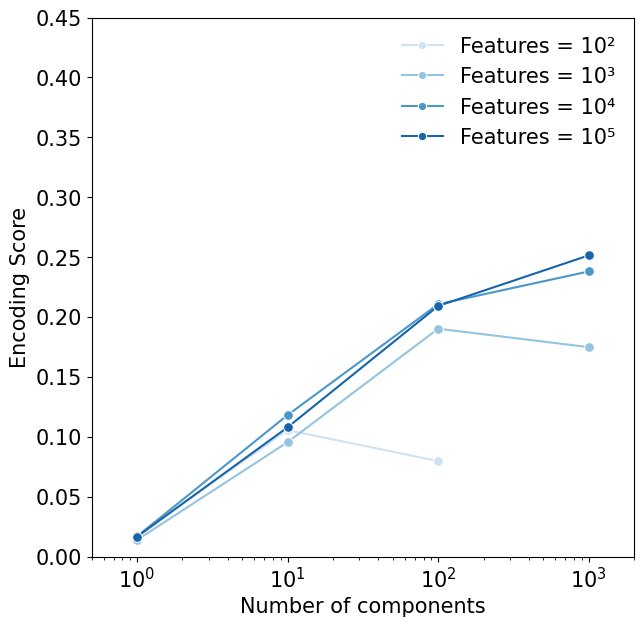

In [8]:
rcParams['figure.figsize'] = (7,7)  

ax1 = sns.lineplot(data = df_pcs, x='pcs', y='score', hue='model', dashes=False, marker='o', palette = palette_blues)
  
plt.xlabel("Number of components",size=15)
plt.ylabel('Encoding Score',size=15)
plt.xlim(df_pcs['pcs'].min()/2,df_pcs['pcs'].max()*2)
plt.ylim(0,0.6) if region == 'IT' else plt.ylim(0,0.45)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")    
ax1.legend(frameon=False,fontsize=15)
plt.setp(plt.gca().get_lines(), markersize=7)  # Change 9 to your desired marker size
plt.savefig(f'figures/principal_components_{DATASET}_{region}.png', dpi=200) 
plt.show()

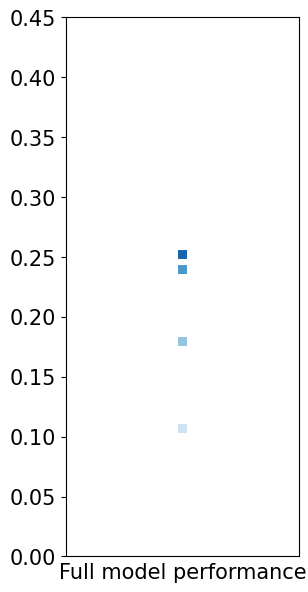

In [9]:
# main results
rcParams['figure.figsize'] = (3,7)  

ax1 = sns.lineplot(data = df_pcs, x='model_family', y='full_model_score', hue='model', dashes=False, style='model_family', marker='s', palette = palette_blues)
plt.xlabel("Full model performance",size=15)
plt.ylabel('')
plt.xlim(-10,10)
plt.ylim(0,0.6) if region == 'IT' else plt.ylim(0,0.45)
ax1.legend_.remove()    
plt.yticks(size=15)
ax1.set_xticks([])
plt.setp(plt.gca().get_lines(), markersize=7)  # Change 9 to your desired marker size
plt.savefig(f'figures/full_model_performance_pcs_{DATASET}_{region}.png', dpi=200) 
plt.show()

# Convolution linear models

#### load bootstrap data

In [19]:
DATASET = 'majajhong' # one of ['majajhong', 'naturalscenes']
region = 'IT' # for majajhong: [V4,IT], for naturalscenes: [early visual stream, midventral visual stream, ventral visual stream]

DATASET = 'naturalscenes'
region = 'ventral visual stream'#, ventral visual stream]

In [20]:
# loading bootstrap data

with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-engineered-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_engineered = pickle.load(file)
    
with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-alexnet-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_alexnet = pickle.load(file)  

In [21]:
df_engineered['features'] = df_engineered['features'].apply(lambda x: int(x)*36)

names ={'expansion':'ReLU','expansion_linear':'Linear'}
df_engineered['model'] = df_engineered['model'].map(names)

palette ={'ReLU':'royalblue','Linear':'orange'}
df_engineered['color'] = df_engineered['model'].map(palette)
df_engineered = df_engineered.dropna(subset='model').reset_index()

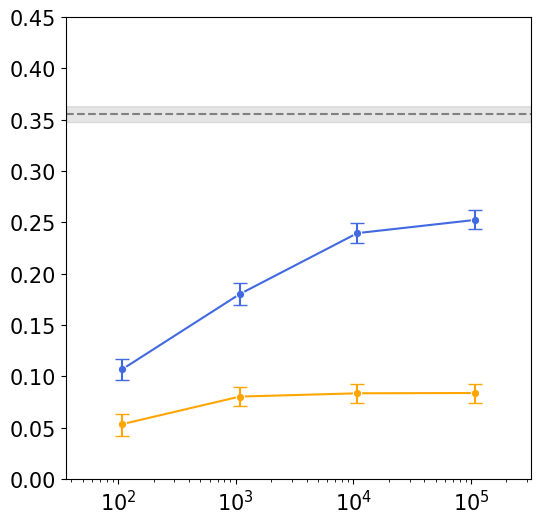

In [22]:
# main results
rcParams['figure.figsize'] = (6,6)  


# main plot
ax1 = sns.lineplot(data = df_engineered, x='features', y='score', hue='model', marker='o',palette = palette)
# adding error bars for the 95% confidence interval
for i in range(len(df_engineered)):
    plt.errorbar(df_engineered['features'][i], df_engineered['score'][i], 
                 yerr=[[df_engineered['score'][i] - df_engineered['lower'][i]], 
                       [df_engineered['upper'][i] - df_engineered['score'][i]]], 
                 fmt='none', capsize=5, color=df_engineered['color'][i])


# alexnet results
plt.axhline(y=df_alexnet['score'][0], color='gray', linestyle='--', label='AlexNet')
# adding confidence interval
plt.fill_between(np.arange(df_engineered['features'].min()/3,df_engineered['features'].max()*3), 
                 df_alexnet['lower'], 
                 df_alexnet['upper'], 
                 color='gray', alpha=0.2)


plt.ylim(0,0.45) if DATASET == 'naturalscenes' else plt.ylim(0,0.65)
plt.xlim(df_engineered['features'].min()/3,df_engineered['features'].max()*3)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")    
plt.xlabel('')
plt.ylabel('')    
ax1.legend(frameon=False,fontsize=12) if region == 'IT' else ax1.legend_.remove()
plt.savefig(f'figures/effects_of_regression_{DATASET}_{region}.png', dpi=200) 
plt.show()

# Fully random models

#### run bootstrap 

In [3]:
#dataset = 'naturalscenes'
dataset = 'majajhong'
info_dict = DATASET_INFO_DICT[dataset]


n_rows = info_dict['test_data_size']
all_sampled_indices = np.random.choice(n_rows, (1000, n_rows), replace=True) # Sample indices for all bootstraps at once

for region in info_dict['regions']:
    
    random_model = get_bootstrap_data(models= ['fully_random'],
                            features=info_dict['expansion_features'],
                            l1_random_filters=[3000],
                            dataset=dataset, 
                            subjects = info_dict['subjects'],
                            layers = 5,
                            file_name = 'random-model',
                            region=region,
                            all_sampled_indices=all_sampled_indices)

  0%|                                                                                                                   | 0/2 [00:00<?, ?it/s]


File not found: fully_random_3000_features=3_layers=5_dataset=majajhong_test, region: V4


  0%|                                                                                                                   | 0/2 [00:00<?, ?it/s]


File not found: fully_random_3000_features=30_layers=5_dataset=majajhong_test, region: V4


  0%|                                                                                                                   | 0/2 [00:00<?, ?it/s]


File not found: fully_random_3000_features=300_layers=5_dataset=majajhong_test, region: V4


  0%|                                                                                                                   | 0/2 [00:00<?, ?it/s]


File not found: fully_random_3000_features=3000_layers=5_dataset=majajhong_test, region: V4


  0%|                                                                                                                   | 0/2 [00:00<?, ?it/s]


File not found: fully_random_3000_features=30000_layers=5_dataset=majajhong_test, region: V4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.40it/s]


#### load bootstrap data

In [4]:
DATASET = 'majajhong' # one of ['majajhong', 'naturalscenes']
region = 'IT' # for majajhong: [V4,IT], for naturalscenes: [early visual stream, midventral visual stream, ventral visual stream]

# DATASET = 'naturalscenes'
# region = 'ventral visual stream'

In [5]:
#load bootstrap data

with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-engineered-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_engineered = pickle.load(file)
    
with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-random-model-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_random = pickle.load(file)  

with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-alexnet-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_alexnet = pickle.load(file)  

In [6]:
df_random['l1_random_filters'] = df_random['l1_random_filters'].apply(lambda x: str(x))
df_random['model'] = df_random['model'] + '_' + df_random['l1_random_filters']
df = pd.concat([df_engineered,df_random]).reset_index(drop=True)
df['features'] = df['features'].apply(lambda x: int(x)*36)


names ={'expansion':'Wavelet filters',
        'fully_random_3000':'Random filters'}


palette ={'Wavelet filters':'royalblue',
         'Random filters':'orchid'}


df['model'] = df['model'].map(names)
df['color'] = df['model'].map(palette)

df = df.dropna(subset=['model']).reset_index(drop=True)

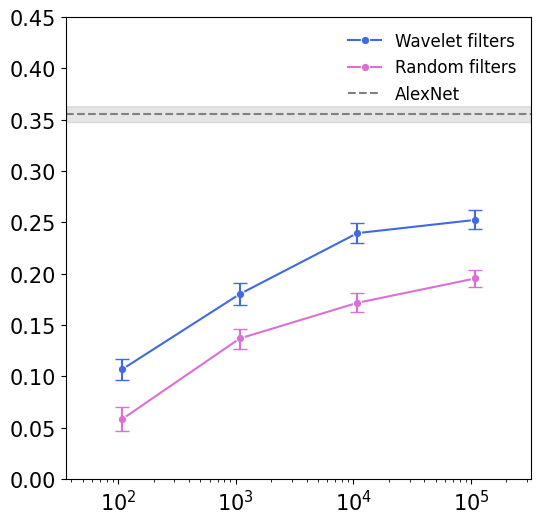

In [65]:
rcParams['figure.figsize'] = (6,6)  

# main plot
ax1 = sns.lineplot(data = df, x='features', y='score', hue='model', marker='o',palette = palette)
# Adding error bars for the 95% confidence interval
for i in range(len(df)):
    plt.errorbar(df['features'][i], df['score'][i], 
                 yerr=[[df['score'][i] - df['lower'][i]], 
                       [df['upper'][i] - df['score'][i]]], 
                 fmt='none', capsize=5, color=df['color'][i])

# alexnet results
plt.axhline(y=df_alexnet['score'][0], color='gray', linestyle='--', label='AlexNet')
# adding confidence interval
plt.fill_between(np.arange(df['features'].min()/3,df['features'].max()*3), 
                 df_alexnet['lower'], df_alexnet['upper'], color='gray', alpha=0.2)


plt.xlabel('')
plt.ylabel('')
plt.ylim(0,0.45) if DATASET == 'naturalscenes' else plt.ylim(0,0.65)
plt.xlim(df['features'].min()/3,df['features'].max()*3)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")    
region == 'IT' if ax1.legend(frameon=False,fontsize=12) else ax1.legend_.remove()  
plt.savefig(f'figures/random_model_{DATASET}_{region}.png', dpi=200) 
plt.show()

# Shuffled pixel results

#### run bootstrap 

In [66]:
#dataset = 'naturalscenes'
dataset = 'majajhong'
info_dict = DATASET_INFO_DICT[dataset]
dataset  = dataset + '_shuffled'


n_rows = info_dict['test_data_size']
all_sampled_indices = np.random.choice(n_rows, (1000, n_rows), replace=True) # Sample indices for all bootstraps at once

for region in info_dict['regions']:
     
    # engineered models 
    get_bootstrap_data(models= ['expansion'],
                        features=info_dict['expansion_features'],
                        dataset=dataset, 
                        subjects=info_dict['subjects'],
                        layers = 5,
                        file_name = 'engineered',
                        region=region,
                        all_sampled_indices=all_sampled_indices)

  0%|                                           | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=3_layers=5_dataset=majajhong_shuffled, region: V4


  0%|                                           | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=30_layers=5_dataset=majajhong_shuffled, region: V4


  0%|                                           | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=300_layers=5_dataset=majajhong_shuffled, region: V4


  0%|                                           | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=majajhong_shuffled, region: V4


  0%|                                           | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=30000_layers=5_dataset=majajhong_shuffled, region: V4


100%|███████████████████████████████████| 2/2 [00:00<00:00,  8.50it/s]


#### load bootstrap data

In [4]:
DATASET = 'majajhong' # one of ['majajhong', 'naturalscenes']
region = 'IT' # for majajhong: [V4,IT], for naturalscenes: [early visual stream, midventral visual stream, ventral visual stream]

# DATASET = 'naturalscenes'
# region = 'ventral visual stream'

In [5]:
# load bootstrap data

with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-expansion-{DATASET}_shuffled-{region}-df.pkl'), 'rb') as file:
    df_engineered_shuffled = pickle.load(file)
    
with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-engineered-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_engineered = pickle.load(file)

with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-alexnet-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_alexnet = pickle.load(file)  

In [6]:
df_engineered['features'] = df_engineered['features'].apply(lambda x: int(x)*36)
df_engineered_shuffled['features'] = df_engineered_shuffled['features'].apply(lambda x: int(x)*36)

df_engineered['dataset'] = 'Local connectivity'
df_engineered_shuffled['dataset'] = 'Dispersed connectivity'

df = pd.concat([df_engineered,df_engineered_shuffled])

names ={'expansion':'Expansion'}
palette ={'Local connectivity':'royalblue','Dispersed connectivity':'indianred'}
df['model'] = df['model'].map(names)
df['color'] = df['dataset'].map(palette)

df = df.dropna(subset='model').reset_index()

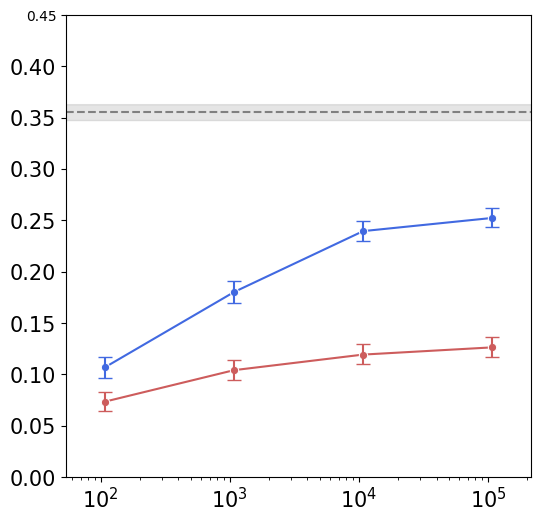

In [74]:
rcParams['figure.figsize'] = (6,6)  

# main plot
ax1 = sns.lineplot(data = df, x='features', y='score', hue='dataset', marker='o',palette = palette)
# adding error bars for the 95% confidence interval
for i in range(len(df)):
    plt.errorbar(df['features'][i], df['score'][i], 
                 yerr=[[df['score'][i] - df['lower'][i]], [df['upper'][i] - df['score'][i]]], 
                 fmt='none', capsize=5, color=df['color'][i])
    
# alexnet results
plt.axhline(y=df_alexnet['score'][0], color='gray', linestyle='--', label='AlexNet')
# adding confidence interval
plt.fill_between(np.arange(df['features'].min()/3,df['features'].max()*3), 
                 df_alexnet['lower'], df_alexnet['upper'], color='gray', alpha=0.2)



plt.xlim(df['features'].min()/2,df['features'].max()*2)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")        
plt.ylim(0,0.65) if region == 'IT' else plt.ylim(0,0.45)
ax1.legend(frameon=False,fontsize=12) if region == 'IT' else ax1.legend_.remove()
plt.xlabel('')
plt.ylabel('')
plt.savefig(f'figures/shuffled_pixels_{DATASET}_{region}.png', dpi=200) 
plt.show()

# Different non-linearities

#### run bootstrap 

In [80]:
dataset = 'naturalscenes'
#dataset = 'majajhong'
info_dict = DATASET_INFO_DICT[dataset]


n_rows = info_dict['test_data_size']
all_sampled_indices = np.random.choice(n_rows, (1000, n_rows), replace=True) # Sample indices for all bootstraps at once

for region in info_dict['regions']:
     
    # engineered models 
    get_bootstrap_data(models= ['expansion'],
                        features=[3000],
                        dataset=dataset, 
                        subjects=info_dict['subjects'],
                        nl_types=['relu','leaky_relu','gelu','elu','abs'],
                        layers = 5,
                        file_name = 'non-linearities',
                        region=region,
                        all_sampled_indices=all_sampled_indices)

  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=naturalscenes_leaky_relu, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=naturalscenes_gelu, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=naturalscenes_elu, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=naturalscenes_abs, region: midventral visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=naturalscenes_leaky_relu, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=naturalscenes_gelu, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=naturalscenes_elu, region: early visual stream


  0%|                                           | 0/8 [00:00<?, ?it/s]

File not found: expansion_features=3000_layers=5_dataset=naturalscenes_abs, region: early visual stream


#### load bootstrap data

In [81]:
DATASET = 'majajhong' # one of ['majajhong', 'naturalscenes']
region = 'IT' # for majajhong: [V4,IT], for naturalscenes: [early visual stream, midventral visual stream, ventral visual stream]

DATASET = 'naturalscenes'
region = 'ventral visual stream'

In [82]:
with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-non-linearities-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df = pickle.load(file)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


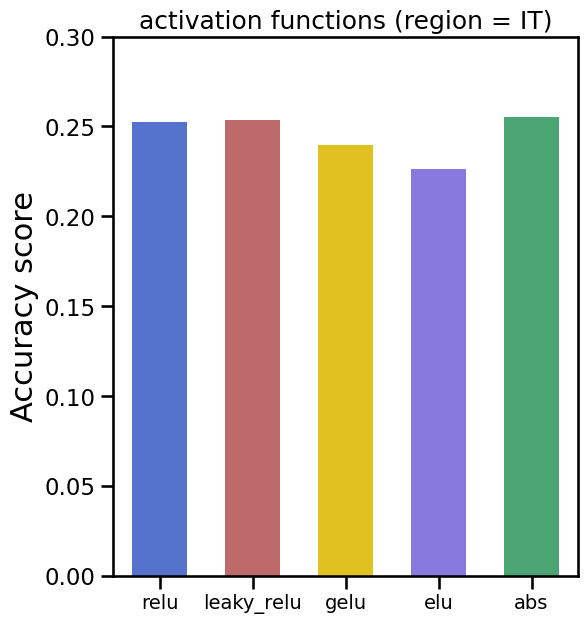

In [86]:
palette = {         
    'relu':'royalblue',
    'gelu':'gold',
    'leaky_relu':'indianred',
    'elu':'mediumslateblue',
    'abs':'mediumseagreen',
}

sns.set_context(context='talk')    
plt.rcParams['figure.figsize'] = (6,7)

ax1 = sns.barplot(x = df['nl_type'], 
                  y = df['score'], 
                       palette=palette,
                       width=0.6, 
                       dodge=False)            
    
ax1.legend().remove()
plt.xlabel('')
plt.ylabel(size=22, ylabel='Accuracy score')    
plt.xticks(size=14)
plt.title('activation functions (region = IT)')
plt.ylim(0,0.65) if region == 'IT' else plt.ylim(0,0.3)
plt.savefig(f'figures/no_labels_nls_{DATASET}_{region}.png', bbox_inches='tight', dpi=300)

# Different initializations

#### run bootstrap 

In [3]:
dataset = 'naturalscenes'
dataset = 'majajhong'
info_dict = DATASET_INFO_DICT[dataset]


n_rows = info_dict['test_data_size']
all_sampled_indices = np.random.choice(n_rows, (1000, n_rows), replace=True) # Sample indices for all bootstraps at once

for region in info_dict['regions']:
     
    # engineered models 
    get_bootstrap_data(models= ['expansion'],
                        features=[3,30,300,3000,30000],
                        dataset=dataset, 
                        subjects=info_dict['subjects'],
                        init_types=['kaiming_uniform','uniform','normal'], #kaiming_normal','orthogonal','xavier_uniform','xavier_normal',
                        layers = 5,
                        file_name = 'init-type-batchnorm',
                        region=region,
                        all_sampled_indices=all_sampled_indices)

  0%|                                                                               | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=3_layers=5_dataset=majajhong_batchnorm, region: V4


  0%|                                                                               | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=3_layers=5_dataset=majajhong_uniform_batchnorm, region: V4


  0%|                                                                               | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=3_layers=5_dataset=majajhong_normal_batchnorm, region: V4


  0%|                                                                               | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=30_layers=5_dataset=majajhong_batchnorm, region: V4


  0%|                                                                               | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=30_layers=5_dataset=majajhong_uniform_batchnorm, region: V4


  0%|                                                                               | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=30_layers=5_dataset=majajhong_normal_batchnorm, region: V4


  0%|                                                                               | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=300_layers=5_dataset=majajhong_batchnorm, region: V4


  0%|                                                                               | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=300_layers=5_dataset=majajhong_uniform_batchnorm, region: V4


  0%|                                                                               | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=300_layers=5_dataset=majajhong_normal_batchnorm, region: V4


  0%|                                                                               | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=majajhong_batchnorm, region: V4


  0%|                                                                               | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=majajhong_uniform_batchnorm, region: V4


  0%|                                                                               | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=3000_layers=5_dataset=majajhong_normal_batchnorm, region: V4


  0%|                                                                               | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=30000_layers=5_dataset=majajhong_batchnorm, region: V4


  0%|                                                                               | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=30000_layers=5_dataset=majajhong_uniform_batchnorm, region: V4


  0%|                                                                               | 0/2 [00:00<?, ?it/s]


File not found: expansion_features=30000_layers=5_dataset=majajhong_normal_batchnorm, region: V4


100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.37it/s]


#### load bootstrap data

In [31]:
DATASET = 'majajhong' # one of ['majajhong', 'naturalscenes']
region = 'IT' # for majajhong: [V4,IT], for naturalscenes: [early visual stream, midventral visual stream, ventral visual stream]

# DATASET = 'naturalscenes'
# region = 'ventral visual stream'

In [32]:
with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-init-type-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df = pickle.load(file)

with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-init-type-batchnorm-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_bn = pickle.load(file)

In [33]:
palette = {         
    'kaiming uniform':'royalblue',
    'kaiming uniform batchnorm':'blue',
    'normal':'gold',
    'normal batchnorm':'orange',
    'kaiming normal':'indianred',
    'xavier uniform':'mediumslateblue',
    'orthogonal':'mediumseagreen',
    'uniform':'pink',
    'uniform batchnorm':'hotpink',
    'xavier normal':'purple'
}

df['features'] = df['features'].apply(lambda x: int(x)*36)
df['init_type'] = df['init_type'].apply(lambda x: x.replace('_',' '))
df['color'] = df['init_type'].map(palette)

df_bn['features'] = df_bn['features'].apply(lambda x: int(x)*36)
df_bn['init_type'] = df_bn['init_type'].apply(lambda x: x.replace('_',' '))
df_bn['init_type'] = df_bn['init_type'] + ' batchnorm'
df_bn['color'] = df_bn['init_type'].map(palette)

In [34]:
df

,model,features,l1_random_filters,pcs,init_type,nl_type,score,lower,upper,color
0,expansion,108,None,None,kaiming uniform,relu,0.315671,0.299740,0.332793,royalblue
1,expansion,108,None,None,kaiming normal,relu,0.206492,0.188076,0.225339,indianred
2,expansion,108,None,None,orthogonal,relu,0.266995,0.248750,0.284964,mediumseagreen
3,expansion,108,None,None,xavier uniform,relu,0.191173,0.171343,0.210927,mediumslateblue
4,expansion,108,None,None,xavier normal,relu,0.224162,0.205160,0.244558,purple
5,expansion,108,None,None,uniform,relu,0.226985,0.210396,0.243841,pink
6,expansion,108,None,None,normal,relu,0.318736,0.303551,0.336264,gold
7,expansion,1080,None,None,kaiming uniform,relu,0.425761,0.411692,0.441174,royalblue
8,expansion,1080,None,None,kaiming normal,relu,0.429178,0.415504,0.443840,indianred
9,expansion,1080,None,None,orthogonal,relu,0.387879,0.373037,0.404190,mediumseagreen


In [35]:
df = pd.concat([df,df_bn]).reset_index(drop=True)

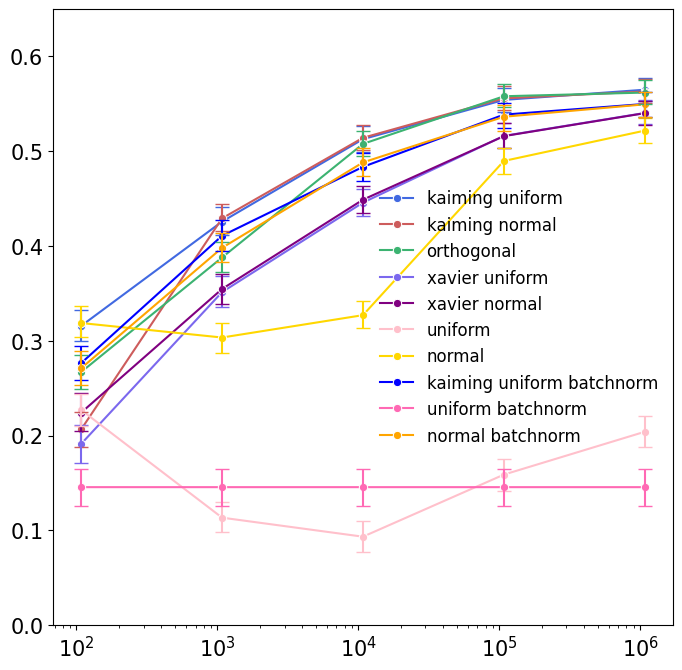

In [36]:

# main results
rcParams['figure.figsize'] = (8,8)  

# main plot
ax1 = sns.lineplot(data = df, x='features', y='score', hue='init_type', marker='o',palette = palette)

# adding error bars for the 95% confidence interval
for i in range(len(df)):
    plt.errorbar(df['features'][i], df['score'][i], 
                 yerr=[[df['score'][i] - df['lower'][i]], 
                       [df['upper'][i] - df['score'][i]]], 
                 fmt='none', capsize=5, color=df['color'][i])


plt.xlabel('')
plt.ylabel('')
plt.ylim(0,0.65) if region == 'IT' else plt.ylim(0,0.3)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")    
ax1.legend(frameon=False,fontsize=12)
plt.savefig(f'figures/init_{DATASET}_{region}.png', dpi=200) 
plt.show()

# Ratios

### main results

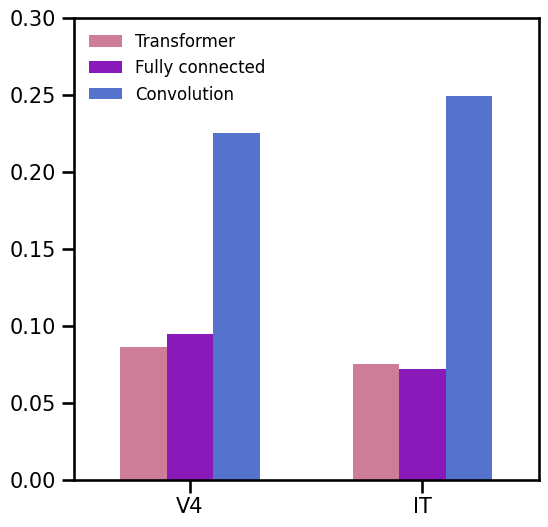

In [109]:

ratios_dict_fc = {'region':[],'dataset':[],'model':[],'smallest model score':[],'largest model score':[],'largest/smallest ratio':[]}
ratios_dict_expansion = {'region':[],'dataset':[],'model':[],'smallest model score':[],'largest model score':[],'largest/smallest ratio':[]}
ratios_dict_vit = {'region':[],'dataset':[],'model':[],'smallest model score':[],'largest model score':[],'largest/smallest ratio':[]}

DATASET = 'majajhong' 
regions = ['V4','IT']


for region in regions:    
    # expansion model and MLP data
    with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-engineered-{DATASET}-{region}-df.pkl'), 'rb') as file:
        df_engineered = pickle.load(file)
    with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-vit-{DATASET}-{region}-df.pkl'), 'rb') as file:
        df_vit = pickle.load(file)    
    
    
    smallest_expansion = float(df_engineered[(df_engineered.model =='expansion') & (df_engineered.features =='3')]['score'])
    largest_expansion = float(df_engineered[(df_engineered.model =='expansion') & (df_engineered.features =='30000')]['score'])
    smallest_fc = float(df_engineered[(df_engineered.model =='fully_connected') & (df_engineered.features =='3')]['score'])
    largest_fc = float(df_engineered[(df_engineered.model =='fully_connected') & (df_engineered.features =='30000')]['score'])
    smallest_vit = float(df_vit[(df_vit.model =='ViT') & (df_vit.features =='12')]['score'])
    largest_vit = float(df_vit[(df_vit.model =='ViT') & (df_vit.features =='6000')]['score'])
    
    #rations
    ratios_dict_fc['region'].append(region)
    ratios_dict_fc['dataset'].append(DATASET)
    ratios_dict_fc['model'].append('fully_connected')
    ratios_dict_fc['largest/smallest ratio'].append(largest_fc-smallest_fc)
    ratios_dict_fc['smallest model score'].append(smallest_fc)
    ratios_dict_fc['largest model score'].append(largest_fc)    
    
    ratios_dict_expansion['region'].append(region)
    ratios_dict_expansion['dataset'].append(DATASET)
    ratios_dict_expansion['model'].append('expansion')
    ratios_dict_expansion['smallest model score'].append(smallest_expansion)
    ratios_dict_expansion['largest model score'].append(largest_expansion)
    ratios_dict_expansion['largest/smallest ratio'].append(largest_expansion-smallest_expansion)

    ratios_dict_vit['region'].append(region)
    ratios_dict_vit['dataset'].append(DATASET)
    ratios_dict_vit['model'].append('ViT')
    ratios_dict_vit['smallest model score'].append(smallest_vit)
    ratios_dict_vit['largest model score'].append(largest_vit)
    ratios_dict_vit['largest/smallest ratio'].append(largest_vit-smallest_vit)
    
rcParams['figure.figsize'] = (6,6)  


df = pd.concat([
                pd.DataFrame.from_dict(ratios_dict_vit),
                pd.DataFrame.from_dict(ratios_dict_fc),
                pd.DataFrame.from_dict(ratios_dict_expansion)
               ]).reset_index(drop=True)

names ={'expansion':'Convolution','ViT':'Transformer','fully_connected':'Fully connected'}
palette ={'Convolution':'royalblue','Transformer':'palevioletred','Fully connected':'darkviolet'}

df['model'] = df['model'].map(names)

ax1 = sns.barplot(x='region', y='largest/smallest ratio', hue='model', width = 0.6, palette=palette, data=df)
plt.xlabel('')
plt.ylabel('')
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylim(0,0.3)
ax1.legend(frameon=False,fontsize=12)
plt.savefig(f'figures/score_difference_{DATASET}_{region}.png', dpi=200) 

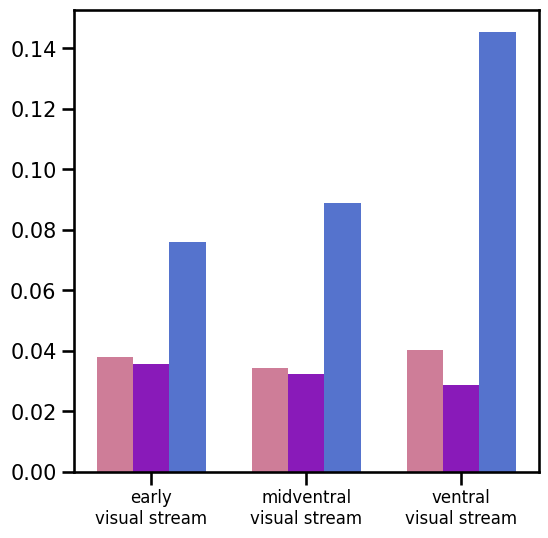

In [110]:

ratios_dict_fc = {'region':[],'dataset':[],'model':[],'smallest model score':[],'largest model score':[],'largest/smallest ratio':[]}
ratios_dict_expansion = {'region':[],'dataset':[],'model':[],'smallest model score':[],'largest model score':[],'largest/smallest ratio':[]}
ratios_dict_vit = {'region':[],'dataset':[],'model':[],'smallest model score':[],'largest model score':[],'largest/smallest ratio':[]}

DATASET = 'naturalscenes'
regions = ['early visual stream', 'midventral visual stream', 'ventral visual stream']
smallest_features = '3'
largest_features = '3000'


for region in regions:    
    # expansion model and MLP data
    with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-engineered-{DATASET}-{region}-df.pkl'), 'rb') as file:
        df_engineered = pickle.load(file)

    with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-vit-{DATASET}-{region}-df.pkl'), 'rb') as file:
        df_vit = pickle.load(file)   
    
    
    
    smallest_expansion = float(df_engineered[(df_engineered.model =='expansion') & (df_engineered.features ==smallest_features)]['score'])
    largest_expansion = float(df_engineered[(df_engineered.model =='expansion') & (df_engineered.features ==largest_features)]['score'])
    smallest_fc = float(df_engineered[(df_engineered.model =='fully_connected') & (df_engineered.features ==smallest_features)]['score'])
    largest_fc = float(df_engineered[(df_engineered.model =='fully_connected') & (df_engineered.features ==largest_features)]['score'])
    smallest_vit = float(df_vit[(df_vit.model =='ViT') & (df_vit.features =='12')]['score'])
    largest_vit = float(df_vit[(df_vit.model =='ViT') & (df_vit.features =='600')]['score'])
    
    #rations
    ratios_dict_fc['region'].append(region)
    ratios_dict_fc['dataset'].append(DATASET)
    ratios_dict_fc['model'].append('fully_connected')
    ratios_dict_fc['largest/smallest ratio'].append(largest_fc-smallest_fc)
    ratios_dict_fc['smallest model score'].append(smallest_fc)
    ratios_dict_fc['largest model score'].append(largest_fc)    
    
    ratios_dict_expansion['region'].append(region)
    ratios_dict_expansion['dataset'].append(DATASET)
    ratios_dict_expansion['model'].append('expansion')
    ratios_dict_expansion['smallest model score'].append(smallest_expansion)
    ratios_dict_expansion['largest model score'].append(largest_expansion)
    ratios_dict_expansion['largest/smallest ratio'].append(largest_expansion-smallest_expansion)
    
    ratios_dict_vit['region'].append(region)
    ratios_dict_vit['dataset'].append(DATASET)
    ratios_dict_vit['model'].append('ViT')
    ratios_dict_vit['smallest model score'].append(smallest_vit)
    ratios_dict_vit['largest model score'].append(largest_vit)
    ratios_dict_vit['largest/smallest ratio'].append(largest_vit-smallest_vit)
    
rcParams['figure.figsize'] = (6,6)  


df = pd.concat([
                pd.DataFrame.from_dict(ratios_dict_vit),
                pd.DataFrame.from_dict(ratios_dict_fc),
                pd.DataFrame.from_dict(ratios_dict_expansion)
               ]).reset_index(drop=True)    
    
names ={'expansion':'Convolution','ViT':'Transformer','fully_connected':'Fully connected'}
palette ={'Convolution':'royalblue','Transformer':'palevioletred','Fully connected':'darkviolet'}

df['model'] = df['model'].map(names)
df['region'] = df['region'].map({'early visual stream':'early\nvisual stream',
                                 'midventral visual stream':'midventral\nvisual stream' ,
                                 'ventral visual stream':'ventral\nvisual stream'})

rcParams['figure.figsize'] = (6,6)  
ax1 = sns.barplot(x='region', y='largest/smallest ratio', hue='model', width=0.7,palette=palette, data=df)
plt.xlabel('')
plt.ylabel('')
plt.xticks(size=12)
plt.yticks(size=15)
ax1.legend_.remove()
plt.savefig(f'figures/score_difference_{DATASET}_{region}.png', dpi=200) 

### factors

In [6]:
palette ={'Dispersed connectivity':'indianred','Linear':'orange','Original architecture':'royalblue'}


diff_dict_shuffled = {'region':[],'dataset':[],'model':[],'smallest model score':[],'largest model score':[],'largest-smallest difference':[]}
diff_dict_expansion = {'region':[],'dataset':[],'model':[],'smallest model score':[],'largest model score':[],'largest-smallest difference':[]}
diff_dict_linear = {'region':[],'dataset':[],'model':[],'smallest model score':[],'largest model score':[],'largest-smallest difference':[]}
DATASET = 'majajhong' 
region = 'IT'

# expansion model and MLP data
with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-engineered-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_engineered = pickle.load(file)
with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-expansion-{DATASET}_shuffled-{region}-df.pkl'), 'rb') as file:
    df_engineered_shuffled = pickle.load(file)
    
smallest_expansion = float(df_engineered[(df_engineered.model =='expansion') & (df_engineered.features =='3')]['score'])
largest_expansion = float(df_engineered[(df_engineered.model =='expansion') & (df_engineered.features =='30000')]['score'])
smallest_shuffled = float(df_engineered_shuffled[(df_engineered_shuffled.model =='expansion') & (df_engineered_shuffled.features =='3')]['score'])
largest_shuffled = float(df_engineered_shuffled[(df_engineered_shuffled.model =='expansion') & (df_engineered_shuffled.features =='30000')]['score'])
smallest_linear = float(df_engineered[(df_engineered.model =='expansion_linear') & (df_engineered.features =='3')]['score'])
largest_linear = float(df_engineered[(df_engineered.model =='expansion_linear') & (df_engineered.features =='30000')]['score'])

#rations
diff_dict_shuffled['region'].append(region)
diff_dict_shuffled['dataset'].append(DATASET)
diff_dict_shuffled['model'].append('Dispersed connectivity')
diff_dict_shuffled['largest-smallest difference'].append(largest_shuffled-smallest_shuffled)
diff_dict_shuffled['smallest model score'].append(smallest_shuffled)
diff_dict_shuffled['largest model score'].append(largest_shuffled)    

diff_dict_expansion['region'].append(region)
diff_dict_expansion['dataset'].append(DATASET)
diff_dict_expansion['model'].append('Original architecture')
diff_dict_expansion['smallest model score'].append(smallest_expansion)
diff_dict_expansion['largest model score'].append(largest_expansion)
diff_dict_expansion['largest-smallest difference'].append(largest_expansion-smallest_expansion)
    
diff_dict_linear['region'].append(region)
diff_dict_linear['dataset'].append(DATASET)
diff_dict_linear['model'].append('Linear')
diff_dict_linear['smallest model score'].append(smallest_linear)
diff_dict_linear['largest model score'].append(largest_linear)
diff_dict_linear['largest-smallest difference'].append(largest_linear-smallest_linear)



# Create the dataframes
df_conectivity = pd.concat([pd.DataFrame.from_dict(diff_dict_expansion), pd.DataFrame.from_dict(diff_dict_shuffled)])
df_conectivity['analysis'] = 'Local connectivity'

df_linarity = pd.concat([pd.DataFrame.from_dict(diff_dict_expansion), pd.DataFrame.from_dict(diff_dict_linear)])
df_linarity['analysis'] = 'Activation function'

# Combine the two dataframes
df = pd.concat([df_conectivity, df_linarity])

# Filter the dataframes correctly
df_connectivity_filtered = df[(df['analysis'] == 'Local connectivity') & (df['model'] != 'Linear')]
df_linearity_filtered = df[(df['analysis'] == 'Activation function') & (df['model'] != 'Dispersed connectivity')]
# Initialize the figure
plt.figure(figsize=(6, 6))

# Plot the connectivity analysis without 'Linear' model
ax1 = sns.barplot(
    x='analysis', 
    y='largest-smallest difference', 
    hue='model', 
    palette=palette, 
    data=df_connectivity_filtered.sort_values(by='model'),
    width=0.5
)

# Plot the linearity analysis without 'Dispersed connectivity' model
ax2 = sns.barplot(
    x='analysis', 
    y='largest-smallest difference', 
    hue='model', 
    palette=palette, 
    data=df_linearity_filtered.sort_values(by='model'),
    dodge=True,
    width=0.5
)

handles_1, labels_1 = ax1.get_legend_handles_labels()
handles_to_display_1 = [handles_1[1], handles_1[0], handles_1[2]]
labels_to_display_1 = [labels_1[1], labels_1[0], labels_1[2]]

ax1.legend(handles_to_display_1, labels_to_display_1, loc='best', frameon=False, fontsize=12)

# Set up the aesthetics
plt.xlabel('')
plt.ylabel('')
plt.xticks(size=15)
plt.yticks(size=15)
#plt.legend(loc='upper right',frameon=False, fontsize=12, )
plt.ylim(0,0.35)
# Save the plot
plt.savefig(f'figures/difference_{DATASET}_{region}.png', dpi=200)
plt.show()


SyntaxError: '[' was never closed (1238314999.py, line 86)

In [8]:
labels_1

['Dispersed connectivity',
 'Original architecture',
 'Linear',
 'Original architecture']

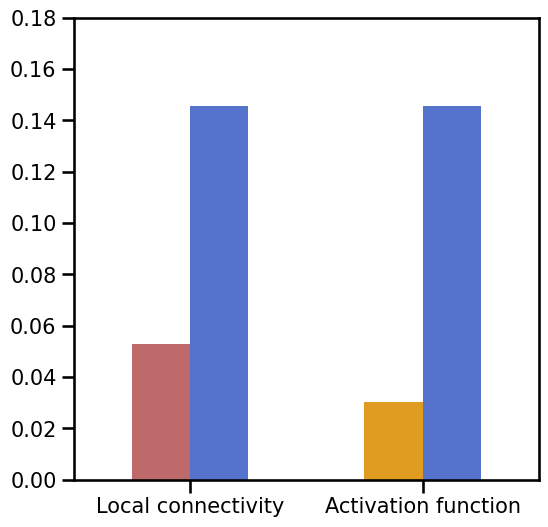

In [116]:
diff_dict_shuffled = {'region':[],'dataset':[],'model':[],'smallest model score':[],'largest model score':[],'largest-smallest difference':[]}
diff_dict_expansion = {'region':[],'dataset':[],'model':[],'smallest model score':[],'largest model score':[],'largest-smallest difference':[]}
diff_dict_linear = {'region':[],'dataset':[],'model':[],'smallest model score':[],'largest model score':[],'largest-smallest difference':[]}
DATASET = 'naturalscenes' 
region = 'ventral visual stream'

# expansion model and MLP data
with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-engineered-{DATASET}-{region}-df.pkl'), 'rb') as file:
    df_engineered = pickle.load(file)
with open(os.path.join(PATH_TO_BOOTSTRAP,f'bootstrap-results-expansion-{DATASET}_shuffled-{region}-df.pkl'), 'rb') as file:
    df_engineered_shuffled = pickle.load(file)
    
smallest_expansion = float(df_engineered[
                           (df_engineered.model =='expansion') & (df_engineered.features =='3')]['score'])
largest_expansion = float(df_engineered[
                          (df_engineered.model =='expansion') & (df_engineered.features =='3000')]['score'])
smallest_shuffled = float(df_engineered_shuffled[
                          (df_engineered_shuffled.model =='expansion') & (df_engineered_shuffled.features =='3')]['score'])
largest_shuffled = float(df_engineered_shuffled[
                         (df_engineered_shuffled.model =='expansion') & (df_engineered_shuffled.features =='3000')]['score'])
smallest_linear = float(df_engineered[
                        (df_engineered.model =='expansion_linear') & (df_engineered.features =='3')]['score'])
largest_linear = float(df_engineered[
                       (df_engineered.model =='expansion_linear') & (df_engineered.features =='3000')]['score'])

#rations
diff_dict_shuffled['region'].append(region)
diff_dict_shuffled['dataset'].append(DATASET)
diff_dict_shuffled['model'].append('Dispersed connectivity')
diff_dict_shuffled['largest-smallest difference'].append(largest_shuffled-smallest_shuffled)
diff_dict_shuffled['smallest model score'].append(smallest_shuffled)
diff_dict_shuffled['largest model score'].append(largest_shuffled)    

diff_dict_expansion['region'].append(region)
diff_dict_expansion['dataset'].append(DATASET)
diff_dict_expansion['model'].append('Original architecture')
diff_dict_expansion['smallest model score'].append(smallest_expansion)
diff_dict_expansion['largest model score'].append(largest_expansion)
diff_dict_expansion['largest-smallest difference'].append(largest_expansion-smallest_expansion)
    
diff_dict_linear['region'].append(region)
diff_dict_linear['dataset'].append(DATASET)
diff_dict_linear['model'].append('Linear')
diff_dict_linear['smallest model score'].append(smallest_linear)
diff_dict_linear['largest model score'].append(largest_linear)
diff_dict_linear['largest-smallest difference'].append(largest_linear-smallest_linear)



# Create the dataframes
df_conectivity = pd.concat([pd.DataFrame.from_dict(diff_dict_expansion), pd.DataFrame.from_dict(diff_dict_shuffled)])
df_conectivity['analysis'] = 'Local connectivity'

df_linarity = pd.concat([pd.DataFrame.from_dict(diff_dict_expansion), pd.DataFrame.from_dict(diff_dict_linear)])
df_linarity['analysis'] = 'Activation function'

# Combine the two dataframes
df = pd.concat([df_conectivity, df_linarity])

# Filter the dataframes correctly
df_connectivity_filtered = df[(df['analysis'] == 'Local connectivity') & (df['model'] != 'Linear')]
df_linearity_filtered = df[(df['analysis'] == 'Activation function') & (df['model'] != 'Dispersed connectivity')]

# Initialize the figure
plt.figure(figsize=(6, 6))

# Plot the connectivity analysis without 'Linear' model
ax1 = sns.barplot(
    x='analysis', 
    y='largest-smallest difference', 
    hue='model', 
    palette=palette, 
    data=df_connectivity_filtered.sort_values(by='model'),
    width=0.5
)

# Plot the linearity analysis without 'Dispersed connectivity' model
ax2 = sns.barplot(
    x='analysis', 
    y='largest-smallest difference', 
    hue='model', 
    palette=palette, 
    data=df_linearity_filtered.sort_values(by='model'),
    dodge=True,
    width=0.5
)

handles_1, labels_1 = ax1.get_legend_handles_labels()
handles_to_display_1 = [handles_1[0], handles_1[1], handles_1[3]]
labels_to_display_1 = [labels_1[0], labels_1[1], labels_1[3]]

ax1.legend(handles_to_display_1, labels_to_display_1, loc='best', frameon=False, fontsize=12)

# Set up the aesthetics
plt.xlabel('')
plt.ylabel('')
plt.xticks(size=15)
plt.yticks(size=15)
#plt.legend(loc='upper right',frameon=False, fontsize=12, )
plt.ylim(0,0.18)
ax1.legend_.remove()
plt.savefig(f'figures/difference_{DATASET}_{region}.png', dpi=200)
plt.show()